## Analysing and Preparing Data

###Charging Data

In [1]:
# Basic example loading images from the svhn dataset

# Dictionaries
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/DeepLearning_2022/PROJECT/Data/'
results_path = '/content/drive/Shared drives/DeepLearning_2022/PROJECT/Results/'

import csv

# Charge the data

#we read the dataset Sentiment140 for tweet polarity --> 1.6M tweets
data_polarity = pd.read_csv(data_path+'Sentiment140.csv',encoding='utf-8')

#we read the dataset TweetsEmotions for tweet emotions --> 9870 tweets
data_emotion = pd.read_csv(data_path+'TweetsEmotions.csv', index_col = 0)
data_emotion2 = pd.read_csv(data_path+'emotions2.csv', index_col = 0)

#we read the datasets
data_emoji = pd.read_csv(data_path+'emoticons_polarity_emotion_filtered.csv',index_col = 0)

Mounted at /content/drive


### Preparing Data Emoji

In [2]:
# Again not all types have the same number of data, dangerous
print(data_emoji)
print(data_emoji["emotion"].value_counts())

                                                  tweet  \
0     The woman who was forced into child labour dur...   
1     A group of children who fled #Mariupol are now...   
2     @MZavala86 @RT_com Dictator Vladimir Putin has...   
3     Yesterday in Brussels during a peaceful strike...   
4     😡 The Russians who left the #Chornobyl nuclear...   
...                                                 ...   
2068  Let’s stop the russian spelling and name it th...   
2069  #Lysychansk after #Putin 🤬 #Лисичанськ #Україн...   
2070  This is really brutal! 🤬\n\nA Ukrainian office...   
2071  Hey #Germany! Are you going to start using #pe...   
2072  Go figure ...India won't condemn Russia for (t...   

                          emoji  polarity  emotion  
0                         ['😭']         0        3  
1                         ['😭']         0        3  
2                         ['😂']         1        1  
3                         ['😓']         0        3  
4                         

In [3]:
data_emoji_1 = data_emoji[data_emoji["polarity"]==1]
data_emoji_1["emotion"].value_counts()

1    1103
2      23
Name: emotion, dtype: int64

In [4]:
for i,row in data_emoji_1.iterrows():
  if (data_emoji_1.loc[i,"emotion"]==2):
    data_emoji_1.loc[i,"emotion"]=0
  elif (data_emoji_1.loc[i,"emotion"]==1):
    data_emoji_1.loc[i,"emotion"]=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
data_emoji_1.head()

,tweet,emoji,polarity,emotion
2,@MZavala86 @RT_com Dictator Vladimir Putin has...,['😂'],1,1
6,@AnonymousVideo I been using https://1920 to s...,['😂'],1,1
9,@AnonymousVideo I been using https://1920 to s...,['😂'],1,1
10,"#Ukraine? Europe? US? UK? #NATO? ""Dark Secret ...",['😂'],1,1
11,Don’t mention the war 😂 \n#UkraineRussiaWar #O...,['😂'],1,1


In [7]:
data_emoji_1["emotion"].value_counts()

print(data_emoji_1["emotion"].value_counts())
data_emoji_1_h = data_emoji_1[data_emoji_1["emotion"] == 0]
data_emoji_1_s = data_emoji_1[data_emoji_1["emotion"] == 1]

data_emoji_1_h = data_emoji_1_h.sample(n=23)
data_emoji_1_s = data_emoji_1_s.sample(n=23)

data_emoji_1 = data_emoji_1_s.append(data_emoji_1_h,ignore_index=True)

from sklearn.utils import shuffle
data_emoji_1 = shuffle(data_emoji_1)

print(data_emoji_1["emotion"].value_counts())

1    23
0    23
Name: emotion, dtype: int64
0    23
1    23
Name: emotion, dtype: int64


###Analysing tweets

##Ukraine Dataset with training

In [8]:
import torch.nn as nn
 
class SentimentalLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(0.3)
        
        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embadding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
        sig_out=self.sigmoid(out)
        
        sig_out=sig_out.view(batch_size, -1)
        sig_out=sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        return (torch.zeros(1, 1, hidden_dim).cuda(),
                torch.zeros(1, 1, hidden_dim).cuda())

###Preparing Data Emotion Polarity 1

In [9]:
import re
from string import punctuation

all_tweets_emoji_1 = list()

for t in data_emoji_1["tweet"]:
  #t = 'a ' + t
  #t = re.sub("(?:\s)@[^, ]*", '', t)
  #t = re.sub("(?:\s)#[^, ]*", '', t)
  t = t[4:]
  t = t.lower()
  t = "".join([ch for ch in t if ch not in punctuation])
  all_tweets_emoji_1.append(t)

all_text = " ".join(all_tweets_emoji_1)
all_words = all_text.split()

In [10]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : ",sorted_words[:10])

Top ten occuring words :  [('to', 29), ('the', 24), ('of', 22), ('amp', 21), ('ukraine', 20), ('russia', 20), ('a', 19), ('in', 15), ('u', 14), ('are', 13)]


In [11]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}

In [12]:
encoded_tweets=list()
iter_1 = 0
iter_2 = 0
for t in all_tweets_emoji_1:
  encoded_tweet=list()
  for word in t.split():
    if word not in vocab_to_int.keys():
      #if word is not available in vocab_to_int put 0 in that place
      encoded_tweet.append(0)
      iter_1 += 1
    else:
      iter_2 += 1
      encoded_tweet.append(vocab_to_int[word])
  encoded_tweets.append(encoded_tweet)
print(iter_1)
print(iter_2)
print(encoded_tweets[0])

0
1267
[15, 24, 10, 25, 33, 34, 35, 21, 3, 2, 26, 19, 7, 36, 37, 38, 39, 27, 12, 40, 5, 6, 41, 42]


In [13]:
sequence_length = 0
for i, tweet in enumerate(encoded_tweets):
  if len(tweet) > sequence_length:
    sequence_length = len(tweet)

features_emoji_1 = []
for i, tweet in enumerate(encoded_tweets):
  tweet_len=len(tweet)
  if (tweet_len<=sequence_length):
    zeros=list(np.zeros(sequence_length-tweet_len))
    new=zeros+tweet
  else:
    new=tweet[:sequence_length]
  features_emoji_1.append(np.array(new))

###Train the model

In [14]:
train_x=features_emoji_1[:int(0.7*len(features_emoji_1))]
train_y=data_emoji_1["emotion"][:int(0.7*len(features_emoji_1))]
valid_x=features_emoji_1[int(0.7*len(features_emoji_1)):int(0.8*len(features_emoji_1))]
valid_y=data_emoji_1["emotion"][int(0.7*len(features_emoji_1)):int(0.8*len(features_emoji_1))]
test_x=features_emoji_1[int(0.8*len(features_emoji_1)):]
test_y=data_emoji_1["emotion"][int(0.8*len(features_emoji_1)):]
print(len(train_y), len(valid_y), len(test_y))

32 4 10


In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(train_x).to(torch.int64), torch.FloatTensor(train_y.to_numpy(dtype=np.float64)).to(torch.int64))
valid_data=TensorDataset(torch.FloatTensor(valid_x).to(torch.int64), torch.FloatTensor(valid_y.to_numpy(dtype=np.float64)).to(torch.int64))
test_data=TensorDataset(torch.FloatTensor(test_x).to(torch.int64), torch.FloatTensor(test_y.to_numpy(dtype=np.float64)).to(torch.int64))

#dataloader
batch_size=64
train_loader=DataLoader(train_data, batch_size=1, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=1, shuffle=True)
test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """


In [16]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([1, 51])
Sample input: 
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0, 321, 132, 322, 323, 324,  11, 325,  30,
         326, 327, 328, 329, 330, 331, 332,  81, 333]])
Sample label size:  torch.Size([1])
Sample label: 
 tensor([1])


In [17]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 1

net = SentimentalLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentalLSTM(
  (embedding): Embedding(663, 400)
  (lstm): LSTM(400, 256, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [18]:
import torch
# loss and optimization functions
lr=0.0001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params

epochs = 20# 3-4 is approx where I noticed the validation loss stop decreasing

training_loss=[]
validation_loss=[]

counter = 0
print_every = 20
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            error = 0
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                if(train_on_gpu):
                  inputs, labels = inputs.cuda(), labels.cuda()  
                
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                
            training_loss.append(loss)
            validation_loss.append(np.mean(val_losses))
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/20... Step: 20... Loss: 0.261690... Val Loss: 0.248622
Epoch: 2/20... Step: 40... Loss: 0.240573... Val Loss: 0.240874
Epoch: 2/20... Step: 60... Loss: 0.242339... Val Loss: 0.236557
Epoch: 3/20... Step: 80... Loss: 0.247116... Val Loss: 0.229704
Epoch: 4/20... Step: 100... Loss: 0.201151... Val Loss: 0.225560
Epoch: 4/20... Step: 120... Loss: 0.178352... Val Loss: 0.221613
Epoch: 5/20... Step: 140... Loss: 0.206167... Val Loss: 0.212929
Epoch: 5/20... Step: 160... Loss: 0.208962... Val Loss: 0.204777
Epoch: 6/20... Step: 180... Loss: 0.159180... Val Loss: 0.200143
Epoch: 7/20... Step: 200... Loss: 0.135721... Val Loss: 0.193041
Epoch: 7/20... Step: 220... Loss: 0.097906... Val Loss: 0.189162
Epoch: 8/20... Step: 240... Loss: 0.093500... Val Loss: 0.181809
Epoch: 9/20... Step: 260... Loss: 0.093960... Val Loss: 0.178799
Epoch: 9/20... Step: 280... Loss: 0.096822... Val Loss: 0.179978
Epoch: 10/20... Step: 300... Loss: 0.063819... Val Loss: 0.179893
Epoch: 10/20... Step: 320...

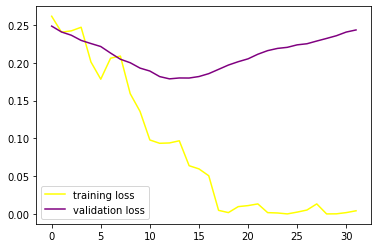

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


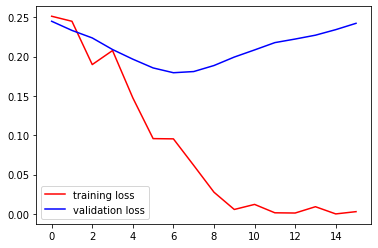

In [19]:
t1 = []
for i in training_loss:
  t1.append(i.cpu().item())


plt.plot(t1,'yellow', label="training loss")
plt.plot(validation_loss, 'purple', label="validation loss")
plt.legend()
plt.show()

t = []
v = []
for i in range(0,20):
  v.append(np.mean(validation_loss[i*2:(i+1)*2]))
  t.append(np.mean(t1[i*2:(i+1)*2]))

plt.plot(t,'red',label='training loss')
plt.plot(v, 'blue', label='validation loss')

plt.legend()
plt.show()

###Test the model

In [20]:
from functools import total_ordering
test_losses = [] # track loss
num_correct = 0
num_happy_correct = 0
num_surprise_correct = 0
total_h = 0
total_s = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

  # Creating new variables for the hidden state, otherwise
  # we'd backprop through the entire training history
  h = tuple([each.data for each in h])
  e=0

  if(train_on_gpu):
    inputs, labels_2 = inputs.cuda(), labels.cuda()

  output, h = net(inputs, h)

  # calculate loss
  test_loss = criterion(output, labels_2.float())
  test_losses.append(test_loss.item())

  # convert output probabilities to predicted class (0 or 1)
  #pred = torch.round(output.squeeze())  # rounds to the nearest integer
  # compare predictions to true label
  #correct_tensor = pred.eq(labels.view_as(pred))

  if labels[0].numpy()==1:
    total_h +=1
    if round(output.cpu().detach().numpy()[0],0) == 1:
      num_happy_correct += 1
      num_correct += 1
  if labels[0].numpy()==0:
    total_s +=1
    if round(output.cpu().detach().numpy()[0],0) == 0:
      num_surprise_correct += 1
      num_correct += 1

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data

test_acc = num_correct/len(test_loader.dataset)
test_acc_h = num_happy_correct/total_h
test_acc_s = num_surprise_correct/total_s
print("Test accuracy: {:.3f}".format(test_acc))
print("Test happy accuracy: {:.6f}".format(test_acc_h))
print("Test surprise accuracy: {:.6f}".format(test_acc_s))

Test loss: 0.238
Test accuracy: 0.500
Test happy accuracy: 0.285714
Test surprise accuracy: 1.000000
